## Load Models

In [265]:
%matplotlib inline
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from collections import Counter, defaultdict
from scipy.spatial.distance import cosine
from gensim.models import word2vec
import seaborn as sns
import random
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

plt.style.use('seaborn') 

In [123]:
get_year = lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1])
average_vector = lambda words,model : np.mean([model.wv.__getitem__(w) for w in words if w in model],axis=0)

In [116]:
paths = [(p,get_year(p)) for p in glob("data/simon/embeddings_DH2019_hengchen-ros-marjanen-2019-07-07 (1)/NL_diachronic/models/*.w2v")]
paths_filt = [t for t in paths if t[1] >=1800]
paths_filt

[('data/simon/embeddings_DH2019_hengchen-ros-marjanen-2019-07-07 (1)/NL_diachronic/models/model_nl_1820.w2v',
  1820),
 ('data/simon/embeddings_DH2019_hengchen-ros-marjanen-2019-07-07 (1)/NL_diachronic/models/model_nl_1840.w2v',
  1840),
 ('data/simon/embeddings_DH2019_hengchen-ros-marjanen-2019-07-07 (1)/NL_diachronic/models/model_nl_1880.w2v',
  1880),
 ('data/simon/embeddings_DH2019_hengchen-ros-marjanen-2019-07-07 (1)/NL_diachronic/models/model_nl_1860.w2v',
  1860),
 ('data/simon/embeddings_DH2019_hengchen-ros-marjanen-2019-07-07 (1)/NL_diachronic/models/model_nl_1800.w2v',
  1800)]

In [117]:
models = {y:word2vec.Word2Vec.load(p) for p,y in paths_filt}

In [199]:
models[1800].wv.vocab["behagen"].count

2125

In [296]:
models[1880].most_similar('nationaal')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('christelijk', 0.7262287735939026),
 ('internationaal', 0.6904023885726929),
 ('vaderlandsch', 0.6763685345649719),
 ('christelyk', 0.6680269837379456),
 ('„nationaal', 0.6612361669540405),
 ('patriottisch', 0.6569185853004456),
 ('christelgk', 0.6528066396713257),
 ('dynastiek', 0.651086688041687),
 ('staatkundig', 0.6475960612297058),
 ('maatschappelijk', 0.6423165798187256)]

## collect neighbouring words across models

In [255]:
#seed = ["vrouw","vrouwe","vrouwen"]
#seed = ["moeder","moeders"]
#seed = ['man','mannen']
#seed = ['vader','vaders']
#seed = ['mensch','menschen','mensen']
seed = ['zacht','bedaard','teeder','geduldig','kalm','zwak','liefelijk','goedig','zagt','zachtkens','goedig',"arme"]
#seed = ['vrouw','vrouwen','moeder','moeders']
#seed = ['man','mannen','mau','heer',"vader","vaders",'grootvader','schoonvader','broeder','zoon']
#seed = ["levendig","gelukkig","welvarend"]
seed = ["huis","huys"]

In [256]:
def get_neighbours(seed):
    neighbours = [] 
    
    for year in sorted(models.keys()):
        av_vector = average_vector(seed,models[year])
        neighbours.extend([w for w,v in models[year].wv.similar_by_vector(av_vector,topn=50)])
    
    return Counter(neighbours)

ns = get_neighbours(seed)
ns.most_common()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


[('huis', 5),
 ('huls', 5),
 ('kuis', 5),
 ('.huis', 5),
 ('hois', 5),
 ('liuis', 5),
 ('iiuis', 5),
 ('hui*', 5),
 ('hais', 5),
 ('huisje', 5),
 ('hnis', 5),
 ('buis', 5),
 ("'huis", 4),
 ('hüis', 4),
 ('huts', 4),
 ("hl'is", 4),
 ('hits', 4),
 ('winkelhuis', 4),
 ('uuis', 4),
 ('woonhuis', 4),
 ('pakhuis', 4),
 ('huia', 4),
 ('hofje', 4),
 ('huys', 3),
 ('-huis', 3),
 ('winkel-huis', 3),
 ('iluis', 3),
 ('hms', 3),
 ('ruis', 3),
 ('lluis', 3),
 ('hujs', 2),
 ('hufs', 2),
 ('huis.', 2),
 ('huïs', 2),
 ('hüys', 2),
 ('huvs', 2),
 ('hu-s', 2),
 ('pak-huis', 2),
 ('huisenerve', 2),
 ('ucis', 2),
 ('kuys', 2),
 ('huisen', 2),
 ('hu.s', 2),
 ('achterhuis', 2),
 ('hiiis', 2),
 ('boerenhuis', 2),
 ('muis', 2),
 ('pakhnis', 2),
 ('hui', 2),
 ('heerenhuis', 2),
 ('buitenverblijf', 2),
 ('straatje', 2),
 ('heis', 2),
 ('hnia', 2),
 ('huig', 2),
 ('bnis', 2),
 ('klooster', 2),
 ('linis', 2),
 ('broodbakkers-huis', 1),
 ('winkel-huys', 1),
 ("'huys", 1),
 ('.huys', 1),
 ('huysen', 1),
 ('huis-en'

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


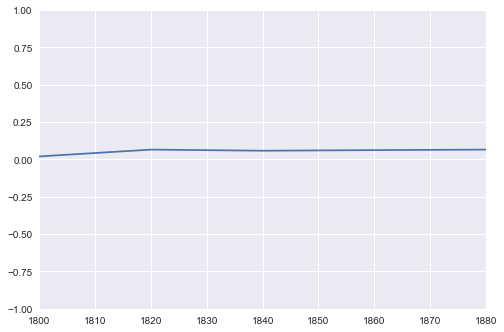

In [163]:
sims_fem = []
sims_male = []
fem_pole = ["vrouw",'viouw','vronw','vrouwen']
#fem_target = ['mensch','menschen','mensen','wezens','menseh','mensehen','menseben']
#fem_target = ['moeder','moeders','grootmoeder','schoonmoeder']
#fem_target = ['kind','kinderen','kindertjes','kinders','kindereu','dochters','zuigeling']
fem_target = ['zacht','bedaard','teeder','geduldig','kalm','zwak','liefelijk','goedig','zagt','zachtkens','goedig']
#fem_target = ['werktuig','machine','machines','stoommachine','stoomwerktuig']
male_pole = ['man','mannen','mau']
#male_target = ['kind','kinderen','kindertjes','kinders','kindereu','dochters','zuigeling']
#male_target = ['mensch','menschen','mensen','wezens','menseh','mensehen','menseben']
#male_target = ['grootvader','vader','vaders','schoonvader',"huisvader"]
#male_taget = ['werktuig','machine','machines','stoommachine','stoomwerktuig']
male_target = ['zacht','bedaard','teeder','geduldig','kalm','zwak','liefelijk','goedig','zagt','zachtkens','goedig']


for year in sorted(models.keys()):
    model = models[year]
    sims_fem.append(1- cosine(average_vector(fem_pole,model),average_vector(fem_target,model)))
    sims_male.append(1- cosine(average_vector(male_pole,model),average_vector(male_target,model)))
    
df = pd.DataFrame(np.array([sims_fem,sims_male]).T,columns=["female",'male'],index=sorted(models.keys()))
df['bias'] = df["female"] - df['male']
df['bias'].plot(ylim=(-1.0,1.0))

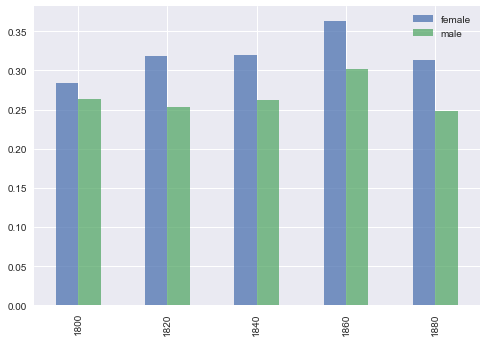

In [164]:
df[["female",'male']].plot(kind='bar',alpha=0.75)

## Contrastive Lexicon Expansion
### Bootstrapped SemAxis

In [259]:
#helper functions


def sort_scores(scores,topn=-1,ascending=False):
    return sorted(scores.items(),key = lambda x: x[1],reverse=not ascending)[:topn]

def top_new(sorted_vocab,seen,topn=10):
    i = 0
    candidates = []
    while len(candidates) < topn:
        if sorted_vocab[i][0] not in seen:
            candidates.append(sorted_vocab[i][0])
        i+=1  
    return candidates

In [346]:
def lex_exp_bootstrap(pole,model,topn=10):
    def topn_new(neighbours,seen):
        neighbours = sorted(neighbours.items(),key=lambda x: x[1], reverse=True)
        i = 0
        candidates = []
        while len(candidates) < min(topn,len(neighbours)):
            if neighbours[i][0] not in seen:
                candidates.append(neighbours[i])
            i+=1
        return dict(candidates)                    
                                    

    seen = pole.copy()
    rounds = 0
    while True:
        try:
            clear_output(wait=True)
            print("words selected :"+ ' '.join(pole))
            neighbours = defaultdict(float)
            for _ in range(10):
                for w,v in model.wv.similar_by_vector(average_vector(sample(list(pole)),model),topn=100):
                    neighbours[w]+=v
            print(len(neighbours))
            neighbours = topn_new(neigbours,seen)
            print(len(neighbours))
            max_val = np.max(list(neighbours.values()))
            neighbours = {w:v/max_val for w,v in neighbours.items()}
            annotations = [(w,int(input(f'Target word="{w}"; value="{round(v,2)}"\n(Options: yes = 1; no = 0)'))) 
                                   for w,v in sorted(neighbours.items(),key=lambda x: x[1])]
            pole.update([w for w,a in annotations if a])
            seen.update([w for w,a in annotations])
            rounds+=1
            
        except KeyboardInterrupt:
            print(f"Leaving after {rounds} annotation rounds.")
            return pole

In [347]:
pole = {"vrouw",'vrouwen',"mevrouw","moeder","moeders",'grootmoeder',"dochter","schoonmoeder"}
pole = lex_exp_bootstrap(pole,models[1880])

words selected :moeder vrouwen mevrouw schoonmoeder moeders grootmoeder dochter vrouw
149


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


AttributeError: 'list' object has no attribute 'items'

In [293]:



def lex_exp_semaxis(pole_1,pole_2,model,topn=10):
    def create_axis(pole1,pole2):
        v1 = np.mean([model.wv[w] for w in pole1 if w in model.wv.vocab],axis=0)
        v2 = np.mean([model.wv[w] for w in pole2 if w in model.wv.vocab],axis=0)
        return v1 - v2

    def sort_vocab_by_axis(axis,model=model):
        def project_word(w):
            return 1 - cosine(model.wv[w],axis)
        return {w : project_word(w) for w in tqdm_notebook(model.wv.vocab)}
    
    seen = set(pole_1).union(pole_2)
    rounds = 0
    

    while True:
        try:
            clear_output(wait=True)
            rounds+=1
            
            print(f"Pole 1 Lexicon (r.{rounds}): " + ' '.join(pole_1))
            print(f"Pole 2 Lexicon (r.{rounds}): " + ' '.join(pole_2))
            axis = create_axis(pole_1,pole_2)
            sorted_vocab = sort_scores(sort_vocab_by_axis(axis))
            for sort_dir in [1,-1]:
                print("\n")
                candidates = [w for w in top_new(sorted_vocab[::sort_dir],seen,topn=topn)]
                annotations = [(w,int(input(f'Target word="{w}"\n(Options: pole_1 = 1,pole_2 = 2, na = 0)'))) for w in candidates]
                pole_1.update([w for w,i in annotations if i==1]);pole_2.update([w for w,i in annotations if i==2])
                seen.update(candidates)

        except KeyboardInterrupt:
            print(f"Leaving after {rounds} annotation rounds.")
            return pole_1,pole_2
        
#pole_1 = {"vrouw","vrouwen","moeder","moeders"}
#pole_2 = {"man","mannen","vader","vaders"}
pole_1 = {'roomschkatholieke','roomsch','roomsch-katholieke','katholieke'}
pole_2 = {'gereformeerde','luthersche','nederlandsch-hervormde','baptisten'}

p1,p2 = lex_exp_semaxis(pole_1,pole_2,models[1880])



Pole 1 Lexicon (r.4): katholieke roomsch klerikale clericale roomschkatholieke ultramontaansche roomsch-katholieke
Pole 2 Lexicon (r.4): lutb horvormdo lnth luthersche gereformeerde hervormdo gertf doopsgezinde luth horv evang baptisten nederlandsch-hervormde


Leaving after 4 annotation rounds.


In [271]:
pole_1 = {"vrouw","vrouwen"}
pole_2 = {"man","mannen"}
pole_1.union(pole_2)

{'man', 'mannen', 'vrouw', 'vrouwen'}

## Compute Bias

In [342]:
bias = defaultdict(list) 
pole_1 = ["vrouw",'viouw','vronw','vrouwen',"mevrouw","moeder","moeders",'grootmoeder','egtgenoote','zufter',"dochter","schoonmoeder","juffer","nicht"]
pole_2 = ['man','mannen','mau','heer',"vader","vaders",'grootvader','schoonvader','broeder','zoon',"broeder","oom","neef"]
#target = ['zacht','bedaard','teeder','geduldig','kalm','zwak','liefelijk','goedig','zagt','zachtkens','goedig','arme']
#target =  ["machine",'werktuig','werktuigen','machines','vervaardigen','werkte','werk','werkjen']
#target = ['kind','kinderen','kindertjes','kinders','kindereu','dochters','zuigeling']
target =  ['mensch','menschen','mensen','wezens','menseh','mensehen','menseben','mens']
#pole_1 = ['katholieke', 'roomsch', 'klerikale', 'clericale', 'roomschkatholieke', 'ultramontaansche', 'roomsch-katholieke']
#pole_2 = ['lutb', 'horvormdo', 'lnth', 'luthersche', 'gereformeerde', 'hervormdo', 'gertf', 'doopsgezinde', 'luth', 'horv', 'evang', 'bapti']
#target = ["nederlandsen","nederlandsch","nederland","vaderlandsch","vaderland"]

def sample(wordlist,cutoff=0.8):
    random.shuffle(wordlist)
    return wordlist[:int(len(wordlist)*cutoff)]

for year,model in tqdm_notebook(sorted(models.items())):
    for _ in range(100):
        p1 = 1 - cosine(average_vector(sample(pole_1),model),average_vector(sample(target),model))
        p2 = 1- cosine(average_vector(sample(pole_2),model),average_vector(sample(target),model))
        bias[year].append(p1-p2)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


In [286]:
def ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

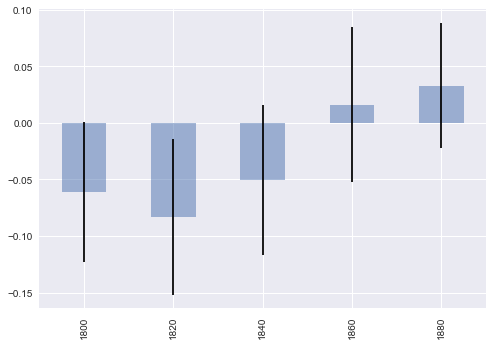

In [343]:
df = pd.DataFrame(np.array([[np.mean(v),np.std(v)] for k,v in bias.items()]),columns=['mean','std'],index=sorted(models.keys()))
df['mean'].plot(kind="bar",yerr=df['std'],align='center',  alpha=0.5, ecolor='black', capsize=10)